In [ ]:
# # Code to download file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# id = '1EnI1mSQcaCQWCkR8kJgRy7610EOyxv0n'
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('data.csv')

In [31]:
import pandas as pd
import numpy as np
data = pd.read_csv("data.csv")
data = data.dropna()
data = data.drop(columns = ['Unnamed: 0','datetime'] )
all_data = data.values
print(all_data)

[[1.40298    1.40366    1.39818    ... 1.39890772 1.41942    1.39337   ]
 [1.39914    1.40018    1.39468    ... 1.39755544 1.41942    1.39337   ]
 [1.3973     1.39872    1.396      ... 1.3964047  1.41942    1.39337   ]
 ...
 [1.19082    1.19405    1.1908     ... 1.17594413 1.19405    1.17625   ]
 [1.19342    1.1966     1.19217    ... 1.17582704 1.1966     1.17625   ]
 [1.19444    1.19503    1.19259    ... 1.17605877 1.1966     1.17625   ]]


In [ ]:
# def maxminnorm(array):
#     maxcols=array.max(axis=0)
#     print(maxcols)
#     mincols=array.min(axis=0)
#     data_shape = array.shape
#     data_rows = data_shape[0]
#     data_cols = data_shape[1]
#     t=np.empty((data_rows,data_cols))
#     for i in range(data_cols):
#         t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
#     return t

In [ ]:
#all_data = maxminnorm(all_data)

In [32]:
from sklearn import preprocessing
all_data = preprocessing.scale(all_data)
#check mean=0, std=1
#all_data.mean(axis = 0)
#all_data.std(axis = 0)
all_data.shape

(17220, 19)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle') #auto select number of dimensions  
pca.fit(all_data)                  
all_data=pca.fit_transform(all_data)   
print(pca.explained_variance_ratio_) 

[9.44550509e-01 5.22183813e-02 2.12483795e-03 4.97311775e-04
 4.43769038e-04 7.67845245e-05 3.38505490e-05 1.71690476e-05
 1.41819895e-05 1.14128683e-05 7.74921927e-06 2.42665827e-06
 1.61598721e-06 8.97788962e-32 5.37857326e-35 7.66825877e-36
 9.69121862e-37 7.05559069e-37]


In [34]:
def input_emb(original_data,seq):
    emb_list = []
    for i in range(0,len(original_data)-seq):
        temp = []
        for j in range(i,i+seq):
            temp.append(original_data[j])
        emb_list.append(temp)
    return emb_list

def label_emb(original_label,seq):
    emb_list = []
    for i in range(seq,len(original_label)):
        emb_list.append(original_label[i])
    return emb_list

In [35]:
def sp(data,co):
  a = int(len(data)*co)
  train = data[0:a]
  test = data[a+1:]
  return train,test

In [36]:
X_train,X_test = sp(all_data.tolist(),0.8)

In [37]:
y_data = data['close'].values
y_train,y_test = sp(y_data.tolist(),0.8)

# _,data_time = sp(date_time_list.tolist(),0.7)
# _,open_data = sp(open_list.tolist(),0.7)
# _,high_data = sp(high_list.tolist(),0.7)
# _,low_data = sp(low_list.tolist(),0.7)

In [ ]:
# test=pd.DataFrame(data=X_test)
# test['datetime'] = None
# test['open'] = None
# test['low'] = None
# test['high'] = None
# test['close'] = None
# test.loc[:,'datetime'] = data_time
# test.loc[:,'open'] = open_data
# test.loc[:,'high'] = high_data
# test.loc[:,'low'] = low_data
# test.loc[:,'close'] = y_test
# print(test)
# test.to_csv('/content/for_backtesting_USD_JPY.csv')

In [38]:
np.array(y_train).shape

(13776,)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim
sequence = 20
input_emb_list_train = input_emb(X_train,sequence)
input_emb_list_val = input_emb(X_test,sequence)
label_emb_list_train = label_emb(y_train,sequence)
label_emb_list_val = label_emb(y_test,sequence)
input_batch_torch = torch.from_numpy(np.array(input_emb_list_train)).float()
target_batch_torch = torch.from_numpy(np.array(label_emb_list_train)).view(-1).float()
val_input = torch.from_numpy(np.array(input_emb_list_val)).float()

val_target =torch.from_numpy(np.array(label_emb_list_val)).view(-1).float()
print(target_batch_torch.numpy().shape)
type(input_batch_torch)

(13756,)


torch.Tensor

In [40]:
n_input = 18
n_hidden = 50
n_class = 1
total_epoch = 500
learning_rate = 0.005

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch.optim as optim
class MAPE(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        sub_t = torch.sub(y, x)
        re = torch.abs(torch.div(sub_t,y))
        
       
        return torch.mean(re)
    
class Correlation(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        mean_x = torch.mean(x)
        mean_y = torch.mean(y)
        
        sub_x = x-mean_x
        sub_y = y-mean_y
        
        sum_mul = torch.sum(torch.mul(sub_x,sub_y))
        
        pow_x = sub_x.pow(2)
        pow_y = sub_y.pow(2)
        
        sum_pow = torch.mul(torch.sum(pow_x),torch.sum(pow_y))
        sqrt_re = sum_pow.sqrt()
        
        return sum_mul/sqrt_re

class Theil_U(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        sub_t = torch.sub(x,y)
        mean_error = torch.mean(sub_t.pow(2)).sqrt()
        mean_squar_x = torch.mean(x.pow(2)).sqrt()
        mean_squar_y = torch.mean(y.pow(2)).sqrt()
        re = mean_error/(mean_squar_x+mean_squar_y)
       
        return re
        
class biLSTM_Attention(nn.Module):

    def __init__(self):

        super(biLSTM_Attention, self).__init__()
        self.bilstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.5)  
        self.linear_1 = nn.Linear(n_input, n_input)
        self.linear_2 = nn.Linear(n_hidden * 2, n_class)

        self.w_omega = nn.Parameter(torch.Tensor(n_hidden * 2, n_hidden * 2))
        self.u_omega = nn.Parameter(torch.Tensor(n_hidden * 2, 1))
        
        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)

    def attention_net(self,x):
      u = torch.tanh(torch.matmul(x, self.w_omega))  
      att = torch.matmul(u, self.u_omega)
      att_score = F.softmax(att, dim=1) 
      scored_x = x * att_score
      context = torch.sum(scored_x, dim=1)
      return context

    def forward(self, x):
        x = self.linear_1(x)
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        bilstm_out, (h_n,c_n) = self.bilstm(x)
        
        attn_output = self.attention_net(bilstm_out) 
        z = self.linear_2(attn_output)
        return z.view(-1)
    
    # Loss function and optimizer
net_bilstm = biLSTM_Attention()
criterion = nn.MSELoss()
optimizer = optim.Adam(net_bilstm.parameters(), lr=learning_rate)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
loss_list_train = []
loss_list_test = []

mape_list_train =[]
mape_list_test =[]

correlation_list_train = []
correlation_list_test = []

Theil_U_list_train =[]
Theil_U_list_test =[]

mape = MAPE()
cor = Correlation()
Theil = Theil_U()
for epoch in range(total_epoch):  
    
    # Set the flag to training
    net_bilstm.train()
    
    # forward + backward + optimize
    outputs= net_bilstm(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch).sqrt()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    net_bilstm.eval()
    output_train = net_bilstm(input_batch_torch) 
    output_test = net_bilstm(val_input)
    
    # Evaluation loss and accuracy calculation
    loss_train = criterion(output_train, target_batch_torch).sqrt()
    loss_test = criterion(output_test,val_target).sqrt()
    loss_list_train.append(loss_train.item())
    loss_list_test.append(loss_test.item())

    loss_mape_train =mape(output_train, target_batch_torch)
    loss_mape_test =mape(output_test,val_target)
    mape_list_train.append(loss_mape_train.item())
    mape_list_test.append(loss_mape_test.item())

    loss_cor_train = cor(output_train, target_batch_torch)
    loss_cor_test = cor(output_test,val_target)
    correlation_list_train.append(loss_cor_train.item())
    correlation_list_test.append(loss_cor_test.item())

    loss_theil_train = Theil(output_train, target_batch_torch) 
    loss_theil_test = Theil(output_test,val_target)
    Theil_U_list_train.append(loss_theil_train.item())
    Theil_U_list_test.append(loss_theil_test.item())
    
    #acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())

    print('Epoch: %d, loss: %.5f' %(epoch + 1, loss_train.item()))

print('Finished Training')


Epoch: 1, loss: 0.97434
Epoch: 2, loss: 0.81485
Epoch: 3, loss: 0.63357
Epoch: 4, loss: 0.46041
Epoch: 5, loss: 0.34722
Epoch: 6, loss: 0.25670
Epoch: 7, loss: 0.29763
Epoch: 8, loss: 0.29082
Epoch: 9, loss: 0.21436
Epoch: 10, loss: 0.10360
Epoch: 11, loss: 0.09768
Epoch: 12, loss: 0.13952
Epoch: 13, loss: 0.12817
Epoch: 14, loss: 0.09168
Epoch: 15, loss: 0.07174
Epoch: 16, loss: 0.07730
Epoch: 17, loss: 0.09539
Epoch: 18, loss: 0.09181
Epoch: 19, loss: 0.05738
Epoch: 20, loss: 0.03023
Epoch: 21, loss: 0.04845
Epoch: 22, loss: 0.05014
Epoch: 23, loss: 0.03978
Epoch: 24, loss: 0.02482
Epoch: 25, loss: 0.03586
Epoch: 26, loss: 0.04765
Epoch: 27, loss: 0.03936
Epoch: 28, loss: 0.02453
Epoch: 29, loss: 0.02615
Epoch: 30, loss: 0.03234
Epoch: 31, loss: 0.02676
Epoch: 32, loss: 0.01105
Epoch: 33, loss: 0.02272
Epoch: 34, loss: 0.02514
Epoch: 35, loss: 0.01584
Epoch: 36, loss: 0.01992
Epoch: 37, loss: 0.02381
Epoch: 38, loss: 0.01684
Epoch: 39, loss: 0.01288
Epoch: 40, loss: 0.01719
Epoch: 41

In [42]:
net = torch.load('bilstm+attention.pt')
output_test = net(val_input)
    

In [43]:
from sklearn.metrics import mean_squared_error
output_test = output_test.detach().numpy()
val_target = val_target.numpy()
rmse = mean_squared_error(output_test,val_target)**(0.5)
rmse

0.004590663850912468

In [ ]:
def mape(pred,)

In [13]:
val_input.size()

torch.Size([3447, 20, 4])

In [ ]:
train_after_train=net_bilstm(input_batch_torch).detach().numpy()
test_after_train =net_bilstm(val_input).detach().numpy()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.save(net_bilstm,'/content/bilstm_model.pt')
model311 = torch.load('/content/bilstm_model.pt')


In [ ]:
test_after_train

array([1.1617559, 1.1613678, 1.1639122, ..., 1.1943684, 1.1974504,
       1.198629 ], dtype=float32)

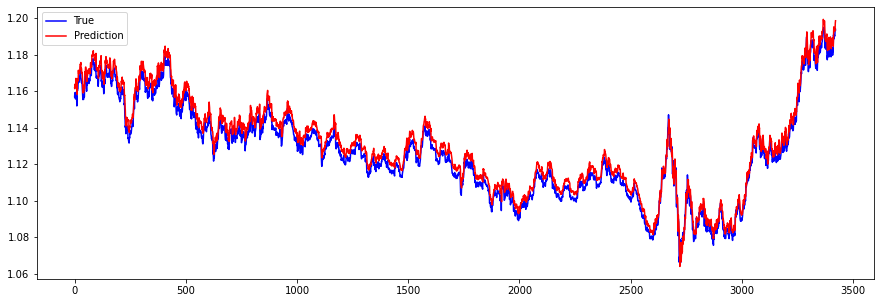

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(label_emb_list_val,'blue',label='True')
plt.plot(test_after_train,'red',label='Prediction')
plt.legend()
plt.show()

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '1ocyyFOSK9ksPMUECThkFOvRCU3gxjeHu'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('bilstm_model.pt')

net = torch.load('bilstm_model.pt')
ot = net(val_input).detach().numpy()

KeyboardInterrupt: ignored

NameError: ignored

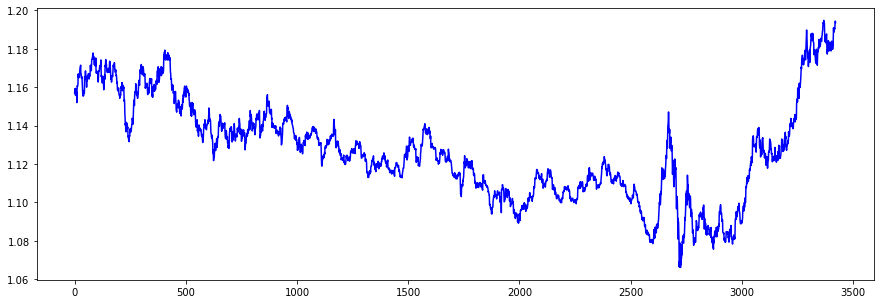

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15,5))
# plt.plot(label_emb_list_val,'blue',label='True')
# plt.plot(ot,'red',label='Prediction')
# plt.legend()
# plt.show()

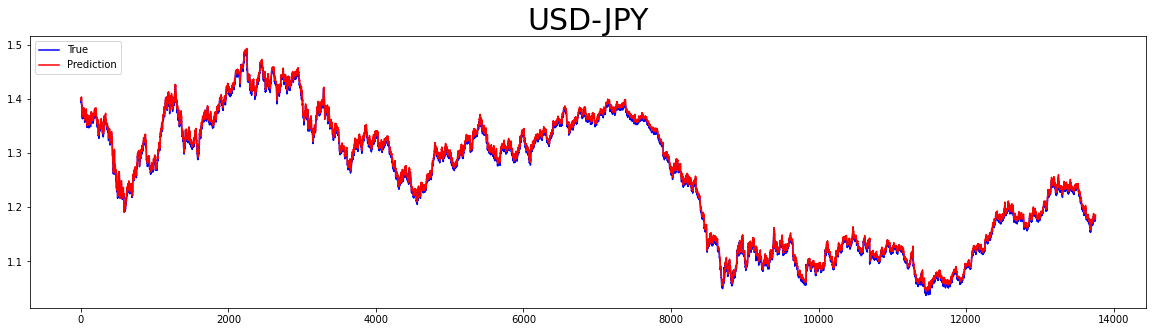

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(target_batch_torch,'blue',label='True')
plt.plot(train_after_train,'red',label='Prediction')

plt.title('USD-JPY',fontsize=  '30')
plt.legend(loc="upper left")

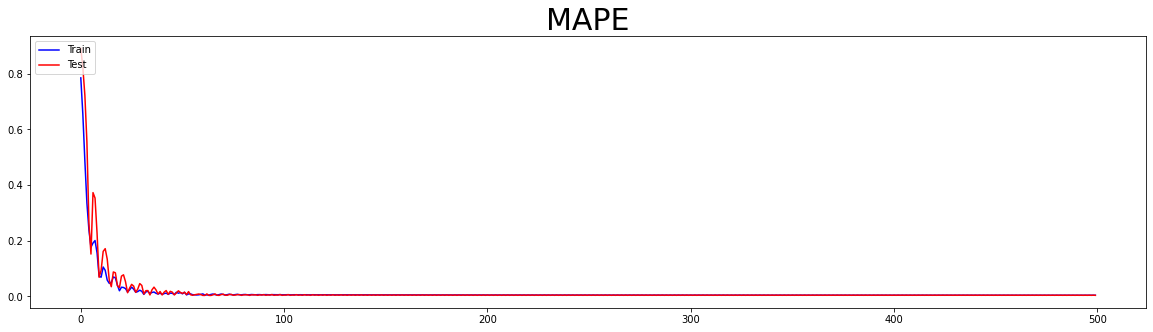

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(mape_list_train,'blue',label='Train')
plt.plot(mape_list_test,'red',label='Test')

plt.title('MAPE',fontsize=  '30')
plt.legend(loc="upper left")

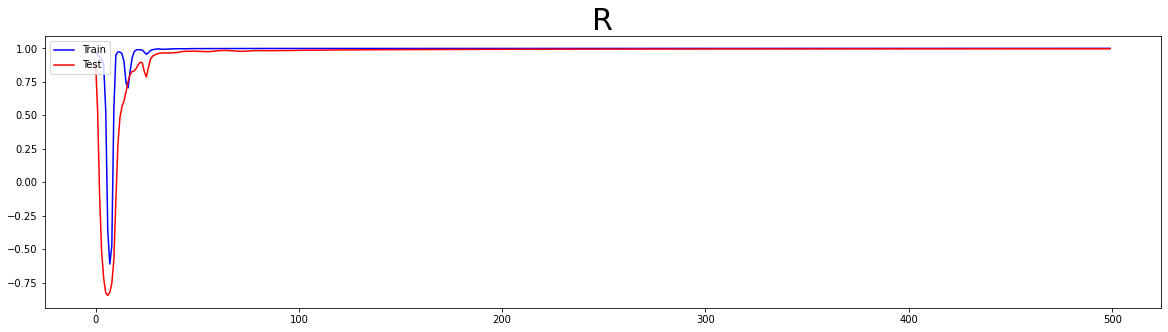

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(correlation_list_train,'blue',label='Train')
plt.plot(correlation_list_test,'red',label='Test')

plt.title('R',fontsize=  '30')
plt.legend(loc="upper left")

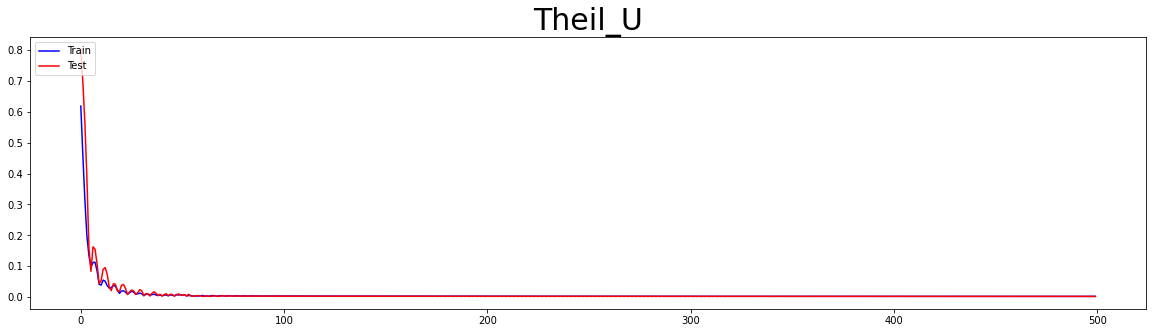

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Theil_U_list_train,'blue',label='Train')
plt.plot(Theil_U_list_test,'red',label='Test')

plt.title('Theil_U',fontsize=  '30')
plt.legend(loc="upper left")

In [ ]:
print('Mape:%.5f, R:%.5f, Theil_U:%.5f'%(mape_list_test[-1],correlation_list_test[-1],Theil_U_list_test[-1]))

Mape:0.00370, R:0.99648, Theil_U:0.00203


In [ ]:
torch.save(net_bilstm,'bilstm+attention.pt')



In [ ]:
name=['close']
test=pd.DataFrame(columns=name,data=test_after_train)
print(test)
test.to_csv('./backtesting_attention_EUR_USD.csv',encoding='gbk')

         close
0     1.161756
1     1.161368
2     1.163912
3     1.162428
4     1.163180
...        ...
3418  1.194076
3419  1.192987
3420  1.194368
3421  1.197450
3422  1.198629

[3423 rows x 1 columns]


In [ ]:
print(mape_list_test.index(min(mape_list_test)))
print(Theil_U_list_test.index(min(Theil_U_list_test)))
print(correlation_list_test.index(max(correlation_list_test)))

64
499
498
